# Transforming the tracking data into a linear space

The tracking data provided in this data set is specified in a geographic reference system. A straightforward vizualisation of it would be to transform it into a local planar and euclidean coordinate system. However for certain cases this might not be the optimal way to represent this data. For example if one wanted to predict a horses next position given its current position at some timestamp, or estimating its win probabilty given its and the other horses position, one would need to take into account the circular nature of the race track that the horses are running on.

A rather straightforward estimator for the latter task would e.g. be to simply look at the euclidean distance from the horses current position in respect to that of the finish line. While for cases close the the finish line this might work well, locations further away along the track could potentially yield shorter distances to the finish line than the length of the path required to actually reach it.

In order to overcome these obstacles we therefore can transform the horse positions further into a different representation. Taking the inner railing of the track as a reference we can might encode a horses position on the track as its orthogonal offset from this railing as well as the forward geodesic distance to the finish line along the railing.

With this representation we, in a sense, transform the curved race track into a straight one by "cutting" the track along the start and finish lines and "bending" it until it becomes straight. In particular, by doing so we overcome the problem of races having more than one passes. 

While for straight sections along the track this mapping is exact, we, by straightening it, actually remove some information from the curved sections with this process. A model predicting the horses position given a previous timestep could, by only looking at this forward and lateral distance, not differntiate between sections which are straight or ones which are actually curved. 

Because of this we add in a third value into this new representation of a horses position, the curvature. Positions along the straight sections of the track get a value of zero, while positions along the curves get the curvature value of the circle underlying this section.

So after this long explanation, let us look at the described transformation with an example.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

from horse_racing.track.track import RaceTrack

To convert from the geograhic reference system into the described one we created the RaceTrack class imported above. Given sample points from a race tracks innermost railing, made up from two straight sections and two circular ones, this class creates a vectorized representation of a track by least-squres-fitting the geometric structures to the sampled data.

This class can then be used to convert from the geograhic coordinate system into the linear one. We already sampled this data for the Aqueduct Race Track. So lets load it in and have a look at it.

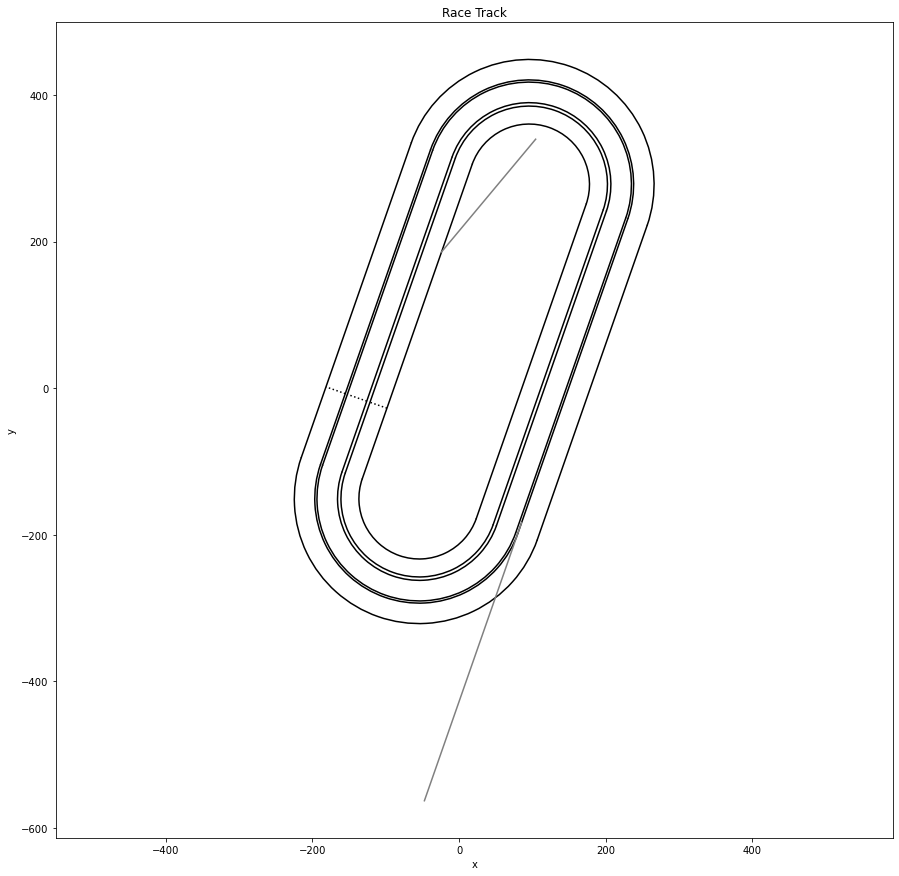

In [6]:
track_dir_path = "./track_data/AQU"
race_track = RaceTrack.from_directory(track_dir_path)

race_track.plot_track()

Let us now visualize a race. 

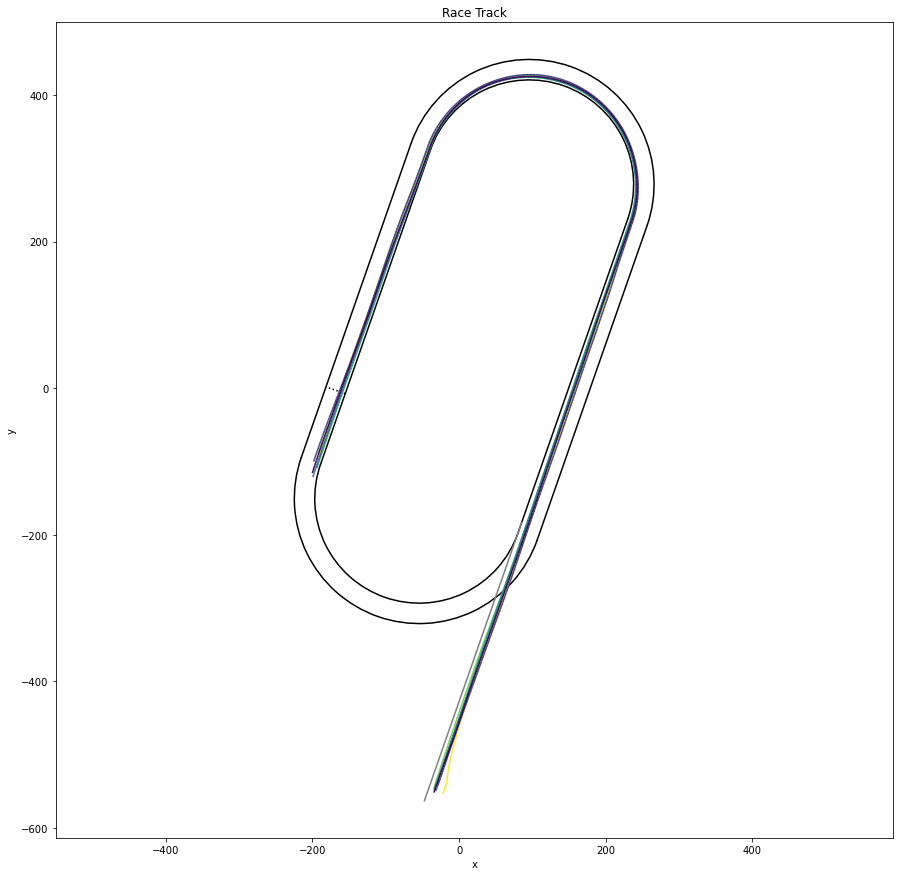

In [7]:
tracking_csv_path = "./csv/nyra_tracking_table.csv"
tracking_data = pd.read_csv(tracking_csv_path)

track_id = "AQU"
course_type = "D"
finish_line = "main"
race_date = "2019-01-01"
race_number = 8

race_data = tracking_data[(tracking_data["track_id"] == track_id) & 
                          (tracking_data["race_date"] == race_date) &
                          (tracking_data["race_number"] == race_number)]

trajectories = []

for program_number in race_data["program_number"].unique():
    program_data = race_data[race_data["program_number"] == program_number]
    
    lat = program_data['latitude'].to_numpy()
    long = program_data['longitude'].to_numpy()
    trakus_index = program_data['trakus_index'].to_numpy()
    
    arg = np.argsort(trakus_index)
    lat = lat[arg]
    long = long[arg]
    
    coords = np.stack([lat, long], axis=-1)
    trajectories.append(coords)
    
trajectories = np.array(trajectories)

race_track.plot_race(trajectories, course_type, finish_line, run_in_id="D")

In the above plot, every horse of the selected race is given a seperate color. However we might also colorize the horses trajectories by their forward distance to the finish line, railing offset and curvature instead.

As the track is quite big, we recommend to vizualize the plots with the interactive version instead. We check out these plots with a new race.

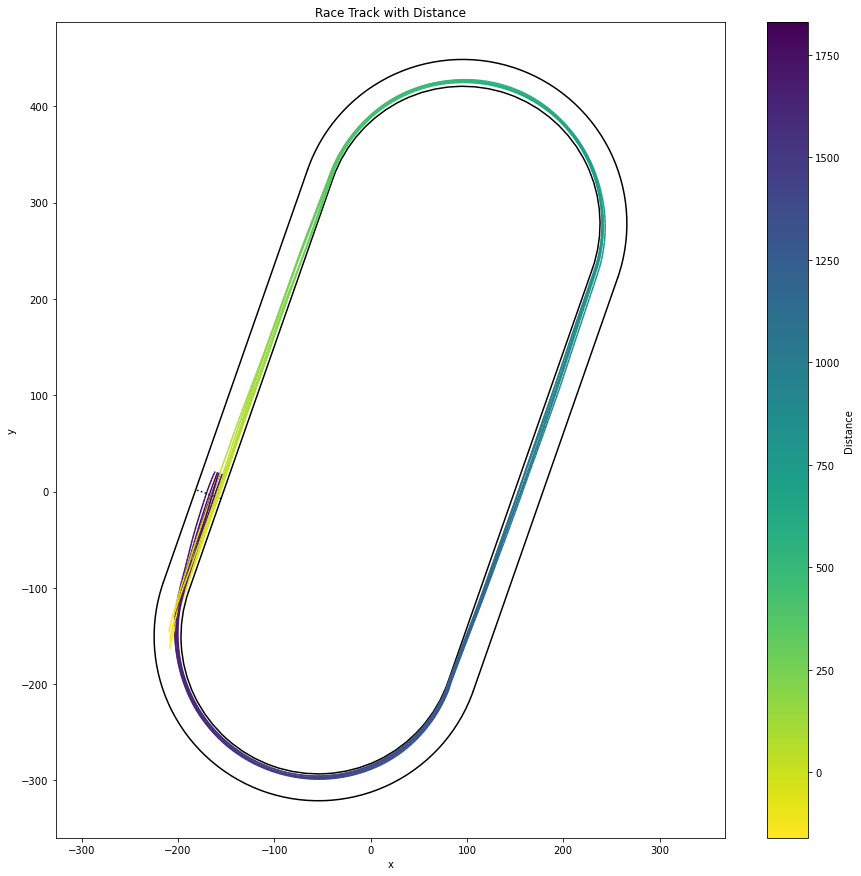

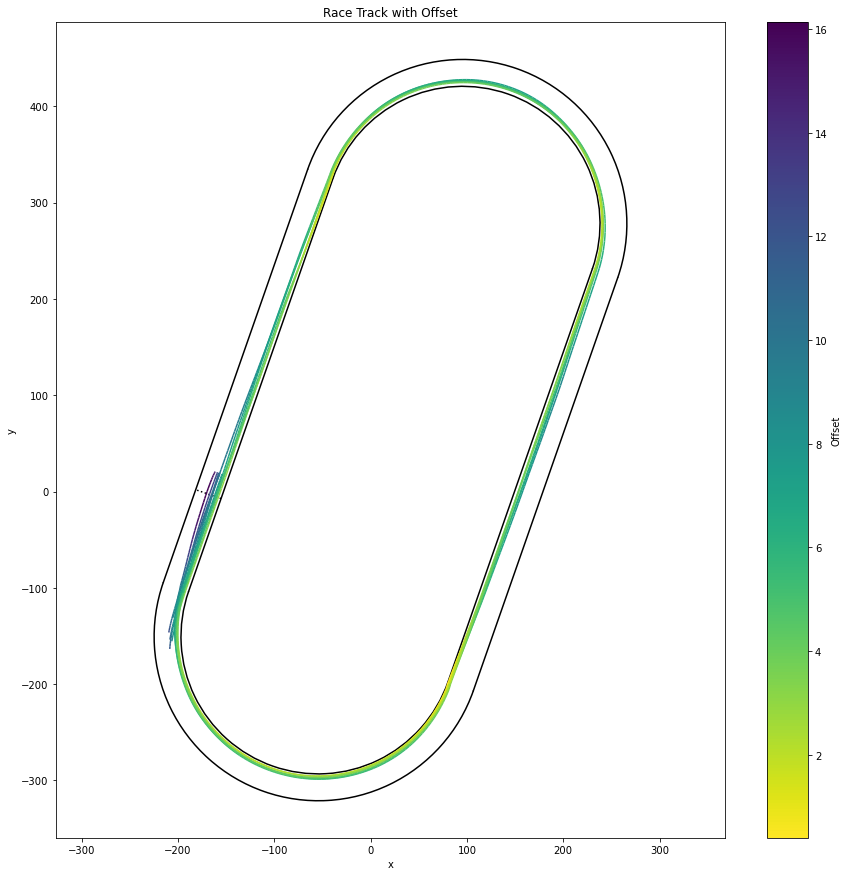

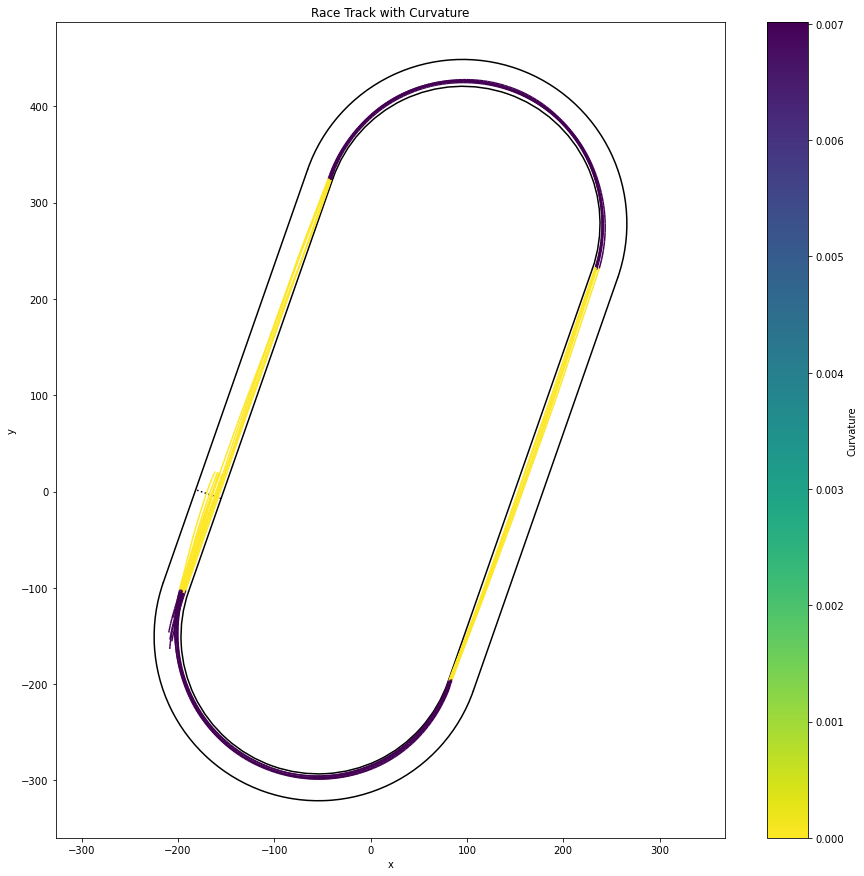

In [8]:
race_number = 4
race_length = 1810.52  # in meters

results = {
    "1  ": "1st",
    "1A ": "4th",
    "3  ": "2nd",
    "4  ": "5th",
    "5  ": "6th",
    "6  ": "3rd"
}

race_data = tracking_data[(tracking_data["track_id"] == track_id) & 
                          (tracking_data["race_date"] == race_date) &
                          (tracking_data["race_number"] == race_number)]

trajectories = []
outcome = []

for program_number in race_data["program_number"].unique():
    program_data = race_data[race_data["program_number"] == program_number]
    
    lat = program_data['latitude'].to_numpy()
    long = program_data['longitude'].to_numpy()
    trakus_index = program_data['trakus_index'].to_numpy()
    
    arg = np.argsort(trakus_index)
    lat = lat[arg]
    long = long[arg]
    
    coords = np.stack([lat, long], axis=-1)
    trajectories.append(coords)

    outcome.append(results[program_number])
    
trajectories = np.array(trajectories)

race_track.plot_race(trajectories, course_type, finish_line, colorize_by="distance")
race_track.plot_race(trajectories, course_type, finish_line, colorize_by="offset")
race_track.plot_race(trajectories, course_type, finish_line, colorize_by="curvature")

As the vectorized representation of the track does not have continous derivatives along the railing, we can observe this step at the places where the half circle becomes a straight line.

So far we are still presenting the horses position data in a planar space, only colorizing the horses trajectories.
Instead we can now visualize the horse paths in our new flattened space as well.

In [9]:
distances, offsets, curvatures = race_track(trajectories, course_type, finish_line)   
# instead of looking at the distance to the finish line we look at the traveled distance
distances = race_length - distances

At first, let's see how the lateral offset and forward distances evolved during the race, where we also take into account the curvature.

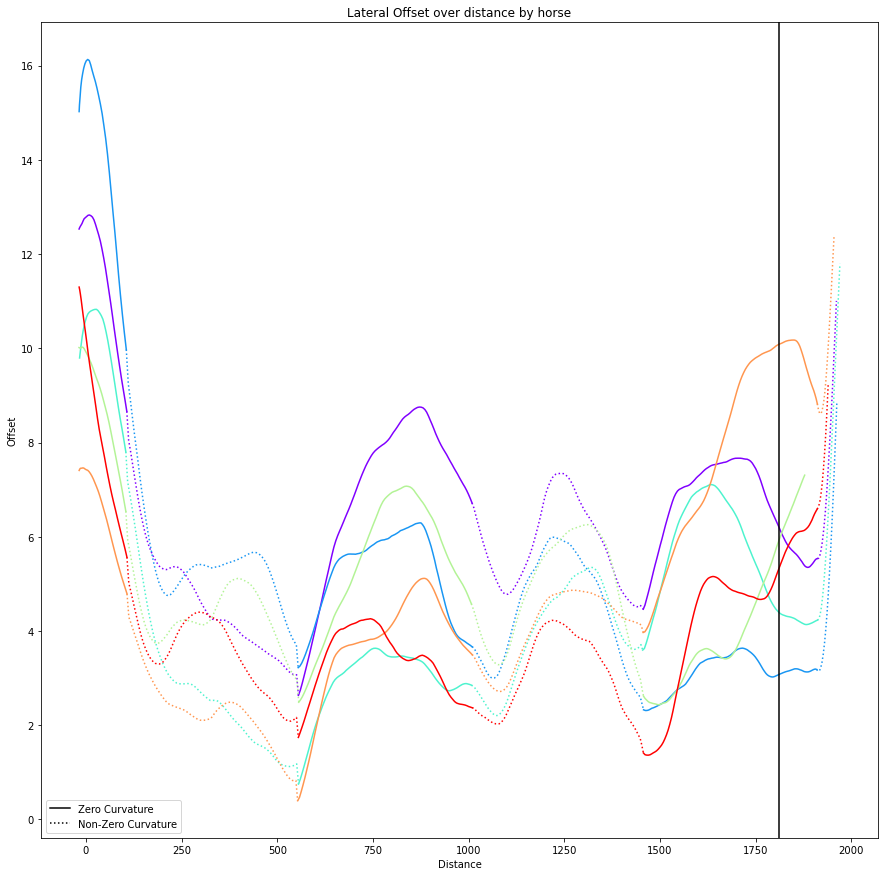

In [10]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(trajectories))))

for distance, offset, curvature in zip(distances, offsets, curvatures):
  color = next(colors)

  x, y, prev_val = [distance[0]], [offset[0]], curvature[0]
  for i, val in enumerate(curvature[1:]):
    x.append(distance[i])
    y.append(offset[i])

    if val != prev_val:
      plt.plot(x, y, c=color, ls="solid" if prev_val == 0 else "dotted")
      x, y = [distance[i]], [offset[i]]

    prev_val = val

  plt.plot(x, y, c=color, ls="solid" if prev_val == 0 else "dotted")

plt.axvline(x=race_length, c="k")
plt.plot([], c="k", label="Zero Curvature")
plt.plot([], c="k", ls="dotted", label="Non-Zero Curvature")
plt.title("Lateral Offset over distance by horse")
plt.xlabel("Distance")
plt.ylabel("Offset")
plt.legend()
plt.show()

From the above plot we can estimate that minimizing the lateral offset from the railing becomes particularly important in the curved sections of the track.

Let us check next how the horses velocities evolve as they traverse the track 

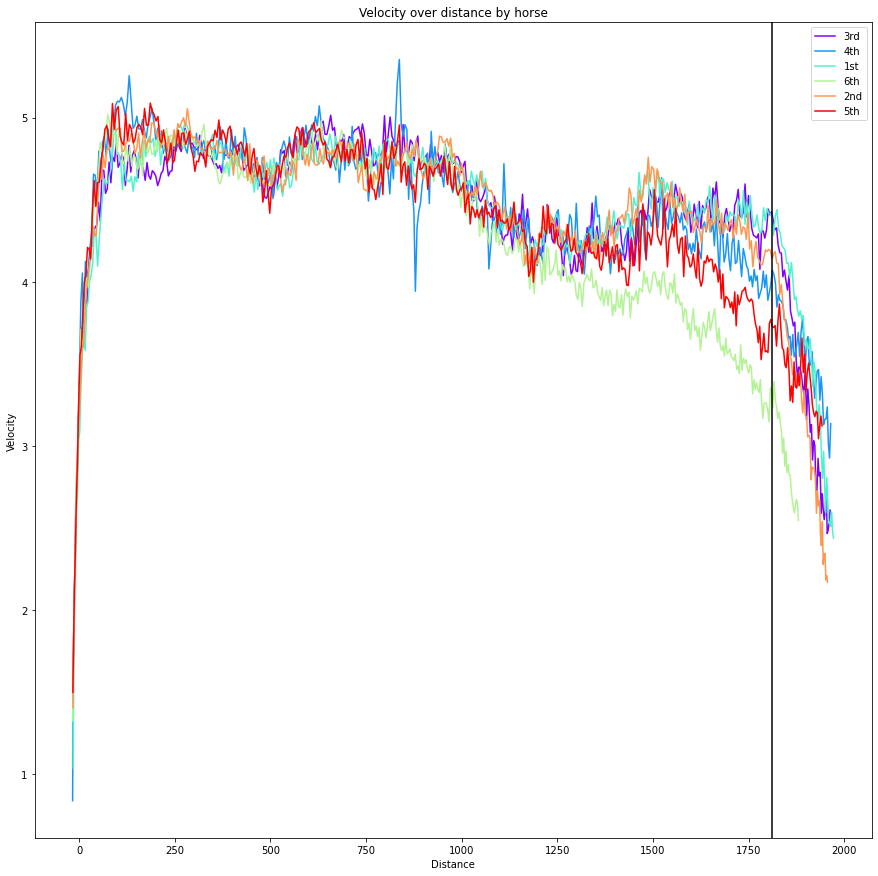

In [11]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(trajectories))))

for index, distance in enumerate(distances):
  color = next(colors)
  plt.plot(distance[1:], np.diff(distance), c=color, label=outcome[index])

plt.axvline(x=race_length, c="k")
plt.title("Velocity over distance by horse")
plt.xlabel("Distance")
plt.ylabel("Velocity")
plt.legend()
plt.show()

Another question we might ask ourselves is how the horses forward distances evolved over the course of the race relative to the position of the leading horse at each timestep.

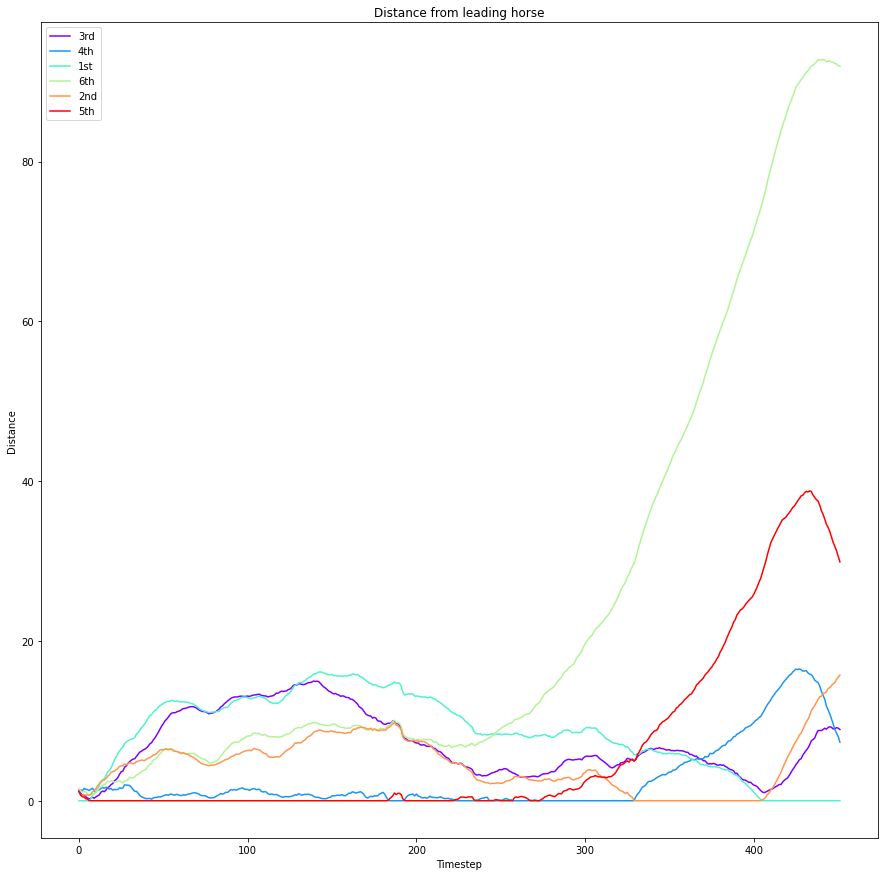

In [12]:
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(trajectories))))

distances_from_leader = np.max(distances, axis=0, keepdims=True) - distances

for index, (distance, distance_from_leader) in enumerate(zip(distances, distances_from_leader)):
  color = next(colors)
  plt.plot(distance_from_leader, c=color, label=outcome[index])

plt.title("Distance from leading horse")
plt.xlabel("Timestep")
plt.ylabel("Distance")
plt.legend()
plt.show()

Looking at the generated plot we observe that the winning horse only managed to aquire the lead position at the very end of the race while even being the last horse at previous timestamps.

Theese are just a few examples of how the explained transformation from the planar euclidean space into another "linear" space opens up the possibility to look at the data from a different angle. Feel free to play around with the code yousrself in order to explore further applications thereof.

The repository containing all the code can be found at https://github.com/DavidBrandes/horse_racing.